## generate_data.py

In [1]:
import csv
import random
from datetime import datetime, timedelta
import json

# Generate data for 50 characters
NUM_ROWS = 1000

# Create the CSV file
OUTPUT_FILE = "troop_movements.csv"


def choose_a_side(home_world):
    """
    Randomly choose an empire or resistance side based on the likelihood 
    that someone from that world would join the rebel alliance.
    Args:
        home_world (dict): The home world data for the character.
    Returns:
        str: The empire or resistance side.
    """
    if home_world["rebel_likelihood"] > random.random():
        return "resistance"
    else:
        return "empire"


# Load home world data from JSON file
with open("home_worlds.json") as json_file:
    home_worlds = json.load(json_file)

# Generate data rows
data_rows = []
for i in range(1, NUM_ROWS + 1):
    # Generate random values for each column
    timestamp = datetime.now() - timedelta(seconds=i)
    unit_id = i
    unit_type = random.choice(
        ["stormtrooper", "tie_fighter", "at-st", "x-wing",
            "resistance_soldier", "at-at", "tie_silencer", "unknown"]
    )
    location_x = random.randint(1, 10)
    location_y = random.randint(1, 10)
    destination_x = random.randint(1, 10)
    destination_y = random.randint(1, 10)

    # Select a random home world from the available options
    home_world = random.choice(home_worlds)
    home_world_name = home_world["name"]
    empire_or_resistance = choose_a_side(home_world)

    # Create the data row
    data_row = [
        timestamp.strftime("%Y-%m-%d %H:%M:%S"),
        unit_id,
        unit_type,
        empire_or_resistance,
        location_x,
        location_y,
        destination_x,
        destination_y,
        home_world_name,
    ]

    # Add the data row to the list
    data_rows.append(data_row)

# Write the data to the CSV file
with open(OUTPUT_FILE, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(
        ["timestamp", "unit_id", "unit_type", "empire_or_resistance", "location_x", "location_y", "destination_x",
         "destination_y", "homeworld"]
    )
    writer.writerows(data_rows)

print("Data generation complete.")


Data generation complete.


### Display troop_movements.csv as DataFrame

In [2]:
import pandas as pd
df = pd.read_csv("troop_movements.csv")
df
    

,timestamp,unit_id,unit_type,empire_or_resistance,location_x,location_y,destination_x,destination_y,homeworld
0,2024-02-07 09:11:05,1,unknown,resistance,1,2,6,3,Mon Cala
1,2024-02-07 09:11:04,2,tie_fighter,empire,8,1,6,6,Haruun Kal
2,2024-02-07 09:11:03,3,tie_silencer,empire,1,8,7,8,Ojom
3,2024-02-07 09:11:02,4,tie_fighter,empire,5,3,6,5,Stewjon
4,2024-02-07 09:11:01,5,x-wing,resistance,9,1,5,8,Kashyyyk
...,...,...,...,...,...,...,...,...,...
995,2024-02-07 08:54:30,996,unknown,empire,6,3,9,7,Umbara
996,2024-02-07 08:54:29,997,resistance_soldier,resistance,5,2,3,3,Iridonia
997,2024-02-07 08:54:28,998,resistance_soldier,empire,3,8,3,2,Kalee
998,2024-02-07 08:54:27,999,at-at,empire,10,3,9,9,Concord Dawn


### Part 2: Build a prediction model

In [3]:
# Create grouped data showing counts of empire vs resistance.
er = df.groupby("empire_or_resistance").size().reset_index(name="count")
print(er.head())

  empire_or_resistance  count
0               empire    521
1           resistance    479


In [4]:
# Create grouped data showing counts of characters by homeworld
homeworld_counts = df.groupby("homeworld").size().reset_index(name="count")
print(homeworld_counts.head())


     homeworld  count
0     Alderaan     23
1  Aleen Minor     18
2   Bestine IV     19
3        Cerea     17
4     Champala     26


In [5]:
# Created grouped data showing counts of characters by unit_type
# Create grouped data showing counts of characters by homeworld
homeworld_counts = df.groupby("unit_type").size().reset_index(name="count")
print(homeworld_counts.head())


            unit_type  count
0               at-at    141
1               at-st    119
2  resistance_soldier    137
3        stormtrooper    103
4         tie_fighter    133


In [6]:
# Engineer a new feature called is_resistance with a True or False value based on empire_or_resiatance
df['is_resistance'] = df["empire_or_resistance"].map(lambda x: x == "resistance")
df.head()

,timestamp,unit_id,unit_type,empire_or_resistance,location_x,location_y,destination_x,destination_y,homeworld,is_resistance
0,2024-02-07 09:11:05,1,unknown,resistance,1,2,6,3,Mon Cala,True
1,2024-02-07 09:11:04,2,tie_fighter,empire,8,1,6,6,Haruun Kal,False
2,2024-02-07 09:11:03,3,tie_silencer,empire,1,8,7,8,Ojom,False
3,2024-02-07 09:11:02,4,tie_fighter,empire,5,3,6,5,Stewjon,False
4,2024-02-07 09:11:01,5,x-wing,resistance,9,1,5,8,Kashyyyk,True


<Axes: xlabel='empire_or_resistance', ylabel='count'>

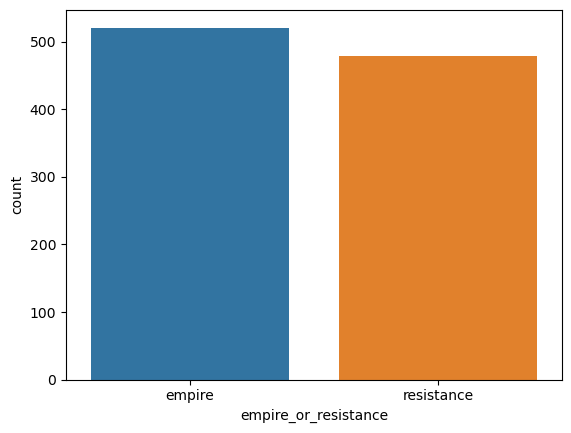

In [7]:
# Create a bar plot using Seaborn showing Empire vs Resistance distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x = 'empire_or_resistance',y='count',data = er)

In [13]:
# Create a prediction model using sklearn.tree.DecisionTreeClassifier that predicts if a character is joining either the Empire or the Resistance based on their homeworld and unit_type.
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [9]:
features = ["homeworld","unit_type"]
X = df[features]
y = df.empire_or_resistance

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
enc = OrdinalEncoder()


In [11]:
# Convert categorical features to numeric using pd.get_dummies.

In [12]:
# Create a bar plot that shows feature importance.
# Example code to get feature importance:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to hold the feature importances
feature_importances = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': importances})


NameError: name 'model' is not defined

In [ ]:
# Save to model as a pickle file named trained_model.pkl

### Part 3: Use the trained model with “real” data

Load data from troop_movements10m.csv (see Guided Project zip for file). This file contains 10 million records to be predicted. 
This data must be cleaned up a bit before it can be used:

⦁	Some unit_type records have a value of invalid_unit. Replace that with unknown.

⦁	Some location_x and location_Y values are missing. Use the ffill method to fill.

⦁	Save the clean data into a Parquet file named troop_movements10m.parquet.

⦁	You need to install pyarrow and fastparquet to support saving to a Parquet file.

pip install pyarrow

pip install fastparquet

Load the pickled model and load the data from the Parquet file into a data frame. Run the data through the model.
